Import needed libarires

In [200]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler

Import Dataset

In [201]:
train = pd.read_csv("./Dataset/train.csv")

Analyze Dataset

Columns:  ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness']
Null values:  0
Duplicates in text row:  74


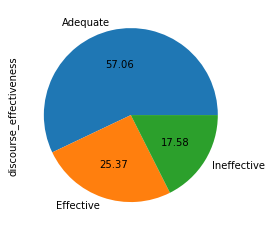

In [202]:
print("Columns: ", list(train.columns))

#Deletes uneeded rows
train.drop(['discourse_id', 'essay_id'] , axis=1, inplace=True)

print("Null values: ", train.isnull().values.sum())
print("Duplicates in text row: ", train["discourse_text"].duplicated().values.sum())

train['discourse_effectiveness'].value_counts().plot.pie(autopct='%.2f')

# ordinally encodes effectivness
train['discourse_effectiveness'] = train["discourse_effectiveness"].replace(
            {"Ineffective": 0, "Adequate": 1, "Effective": 2}
        )

Deals with Duplicates (Duplicates means multiple opinions were given so taking the average)

In [203]:
#creates a df with the average of the duplicates
duplicateAverage = train.loc[train["discourse_text"].duplicated(keep=False)].groupby(['discourse_text']).mean()
print(duplicateAverage.head())

# Drops all the duplicates except one which will be used as the replacement replaced
train = train.loc[~train["discourse_text"].duplicated(keep='first')]

for i, x in train.iterrows():
    text = x.discourse_text
    
    if text in duplicateAverage.index:
        train.at[i, 'discourse_effectiveness'] = duplicateAverage.loc[text]
        

print("\nDuplicates in text row: ", train["discourse_text"].duplicated().values.sum())

                                                    discourse_effectiveness
discourse_text                                                             
"That's a lava dome that takes the form of an i...                      1.0
At the most basic level, the electoral college ...                      1.0
Big States                                                              0.5
I agree                                                                 1.0
I think students should be required to perform ...                      1.0

Duplicates in text row:  0


Feature Creation

In [204]:
def createFeatures(df):
    lengthArr = []
    wordCountArr = []
    sentCountArr = []
    upperCasePerc = []
    averageSentenceWord = []

    for index, row in df.iterrows():
        curText = row.discourse_text
        # lower case conversion
        curText = curText.lower()
        # removes all the trailing and leading spaces
        curText = curText.strip()
        
        # Gets the string length
        stringLength = len(curText)
        lengthArr.append(stringLength)
        #Gets the words
        words = curText.split()
        #Gets the word count
        wordCountArr.append(len(words))
        #Gets the sentences
        sentenceArr = [x for x in re.split(r"[\n\.\?\!]+", text) if len(x) > 0]
        #Gets the sentence count
        sentCountArr.append(len(sentenceArr))
        #Gets the averge words in a sentence
        averageSentenceWord.append(len(words) / len(sentenceArr))
        
        #Gets capitilization of letters percentage
        i = 0
        upper_count = 0
        for sentence in sentenceArr:
            while i < len(sentence):
                if sentence[i].isalpha():
                    if sentence[i].isupper():
                        upper_count = upper_count + 1
                    else:
                        break
                i = i + 1
                
        upperCasePerc.append(upper_count / len(sentenceArr) * 100)
            
    df['StringLength'] = lengthArr
    df['WordCount'] = wordCountArr
    df['SentenceCount'] = sentCountArr 
    df['upperCasePerc'] = upperCasePerc 
    df['averageSentenceWords'] = averageSentenceWord
        
createFeatures(train)
print("Created Train Features")


Created Train Features


Cleans the text

In [205]:
# ########## Clean data
def cleanText(df):

    stopWords = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    for index, row in df.iterrows():

        curText = row.discourse_text

        # lower case conversion
        curText = curText.lower()
        # removes all the trailing and leading spaces
        curText = curText.strip()
        #Removes stop words
        def remove_stop(x):
            return " ".join([word for word in str(x).split() if word not in stopWords])

        curText = remove_stop(curText)
        
        #Replaces - with a spalce
        curText = re.sub(r'-', ' ', curText)
        # removing all non alpha numeric char
        curText = re.sub(r'[^a-z0-9 ]+', '', curText)
        # removing "..." (multiple periods in a row)
        curText = re.sub(r'([.])\1+', '', curText)
        # stems the text
        curText = stemmer.stem(curText)
        # removing multiple spaces in a row
        curText = re.sub(r'(\s\s)+', ' ', curText)
        # replaces the text
        df.at[index, 'discourse_text'] = curText


cleanText(train)

print("Cleaned Train Dataset")

Cleaned Train Dataset


Vectorizes the cleaned text

In [206]:
# Vectorized strings
countVec = CountVectorizer(
    ngram_range=(1,2),
    min_df=15
)

# Fits the vectorized with train data
train_vectors = countVec.fit_transform(train['discourse_text'])

# Gets a list of all the words in the vector
vector_features = countVec.get_feature_names_out()
#print("Vector features: ", vector_features)  # Prints all the words fit intoz the in the vectorizer
print("Feature Counts: ", len(vector_features), "\n\n")  # Prints the amount of words in the vectorizer
# Converts the vectorized data matrix to array
train_vec_arr = train_vectors.toarray()
# Puts the vectorized data into the dataframe
train_vec_dataframe = pd.DataFrame(data=train_vec_arr, columns=vector_features)


Feature Counts:  9676 




One Hot Encondes the discourse type row

In [207]:
# One hot encodes discourse type
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_categorical_OneHot_train = pd.DataFrame(OH_encoder.fit_transform(train[['discourse_type']]))

print("One hot enconded train dataset")

One hot enconded train dataset


Combines the Dataset

In [223]:
def combineDataFrame(dfOg, restDfs):
    df = dfOg.copy()
    # drops the text column as it has been vectorized and type since it's been one hot encoded
    df.drop(['discourse_text', 'discourse_type'], inplace=True, axis=1)
    #resets index to make concat work
    df.reset_index(drop=True, inplace=True)
    for curDf in restDfs:
        #resets index to make concat work
        curDf.reset_index(drop=True, inplace=True)
        df = pd.concat([df, curDf], axis=1)

    return df



# Gets the combined and fully cleaned model
trainFullyCombined = combineDataFrame(train, [X_categorical_OneHot_train, train_vec_dataframe])

print("Fully Combined the Train dataset")

NAN count:  0
NAN count:  0
Fully Combined the Train dataset


Train Test split to make Validation set

In [224]:
#Gets the y value
yFinished = trainFullyCombined['discourse_effectiveness']
#drops the y value
trainFullyCombined.drop('discourse_effectiveness', axis=1, inplace=True)

XTrain, XValid, yTrain, yValid = train_test_split(trainFullyCombined, yFinished, train_size=0.8, test_size=0.2, shuffle=True, random_state=1) 
print("Split into train and validation")

Split into train and validation


C:\Users\jesse\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


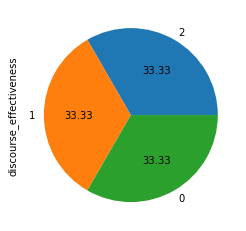

In [225]:


# Performs oversampling with a 1-1 ratio
ros = RandomOverSampler(sampling_strategy='auto',random_state=0)

xResampled, yResampled = ros.fit_resample(XTrain, yTrain)

trainSetFinished = xResampled
trainSetFinished['discourse_effectiveness'] = yResampled

validSetFinished = XValid
validSetFinished['discourse_effectiveness'] = yValid

trainSetFinished['discourse_effectiveness'].value_counts().plot.pie(autopct='%.2f')

In [226]:
print(trainSetFinished.head())
trainSetFinished.to_csv('./Dataset/trainFullyProcessed.csv', index=False)

print(validSetFinished.head())
validSetFinished.to_csv('./Dataset/validFullyProcessed.csv', index=False)

   StringLength  WordCount  SentenceCount  upperCasePerc  \
0           108         17              2           50.0   
1           457         80              2           50.0   
2            49          8              2           50.0   
3           106         19              2           50.0   
4           101         18              2           50.0   

   averageSentenceWords    0    1    2    3    4  ...  youre  yours  yourself  \
0                   8.5  1.0  0.0  0.0  0.0  0.0  ...      0      0         0   
1                  40.0  0.0  1.0  0.0  0.0  0.0  ...      0      0         0   
2                   4.0  1.0  0.0  0.0  0.0  0.0  ...      0      0         0   
3                   9.5  1.0  0.0  0.0  0.0  0.0  ...      0      0         0   
4                   9.0  1.0  0.0  0.0  0.0  0.0  ...      0      0         0   

   youth  zone  zones  zones around  zygomatic  zygomatic major  \
0      0     0      0             0          0                0   
1      0     0    